# Wikidata Archaeological Sites (catacombs) in Italy as Map

This notebook fetches archaeological sites using a SPARQL query from Wikidata and creates maps.

## Define SPARQL query service

In [1]:
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Point
import contextily as ctx  # For adding OpenStreetMap basemaps
from matplotlib.patches import Patch
from scipy.stats import gaussian_kde
import numpy as np

def querySparql(query):
    sparql = SPARQLWrapper("https://query.wikidata.org/sparql")
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    results = sparql.queryAndConvert()
    return results['results']['bindings']

## Define the SPARQL Query

In [2]:
# SPARQL Query
sitesQuery = """
SELECT DISTINCT ?item ?itemLabel ?geo ?img WHERE {
 ?item (wdt:P31/(wdt:P279*)) wd:Q839954.
 ?item wdt:P31 wd:Q172896.
 ?item wdt:P17 wd:Q38.
 ?item wdt:P625 ?geo.
 OPTIONAL { ?item wdt:P18 ?img }
 SERVICE wikibase:label { bd:serviceParam wikibase:language "en". }
}
"""

## Fetch Data and Convert to DataFrame

In [3]:
# Fetch data using the SPARQL query
sparql_results = querySparql(sitesQuery)

# Convert SPARQL JSON results into a DataFrame
data = []
for result in sparql_results:
    geo = result['geo']['value'] if 'geo' in result else None
    lat, lon = (None, None)
    if geo:
        lon, lat = map(float, geo.replace("Point(", "").replace(")", "").split())
    data.append({
        "item": result['item']['value'],
        "itemLabel": result['itemLabel']['value'],
        "latitude": lat,
        "longitude": lon,
    })

df = pd.DataFrame(data)
df

,item,itemLabel,latitude,longitude
0,http://www.wikidata.org/entity/Q112661376,Catacombe del Mulinello,37.236900,15.173755
1,http://www.wikidata.org/entity/Q3663207,Catacomb of San Zotico,41.850465,12.667922
2,http://www.wikidata.org/entity/Q546419,Catacombs of San Sebastiano,41.855762,12.516484
3,http://www.wikidata.org/entity/Q3663192,Catacomb of Commodilla,41.861167,12.483472
4,http://www.wikidata.org/entity/Q3663174,Catacomb of San Castulo,41.886014,12.525928
5,http://www.wikidata.org/entity/Q3663177,Catacombe of San Lorenzo,41.902818,12.521068
6,http://www.wikidata.org/entity/Q3663175,Catacomb of San Nicomede,41.910889,12.507861
7,http://www.wikidata.org/entity/Q3663191,Catacomba maggiore,41.922781,12.518611
8,http://www.wikidata.org/entity/Q3663182,Catacombs of Saint Agnes,41.922778,12.518611
9,http://www.wikidata.org/entity/Q1027069,Catacomb of Callixtus,41.858878,12.511058


## Visualise the Data in a map

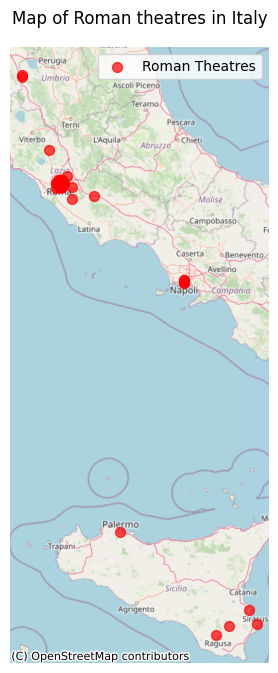

In [ ]:
# Check if DataFrame is populated
if df.empty:
    print("No data retrieved from the query.")
else:
    # Filter rows with valid coordinates
    df_with_coords = df.dropna(subset=['latitude', 'longitude'])

    # Create a GeoDataFrame
    gdf = gpd.GeoDataFrame(
        df_with_coords,
        geometry=[Point(xy) for xy in zip(df_with_coords['longitude'], df_with_coords['latitude'])],
        crs="EPSG:4326"
    )

    # Convert to Web Mercator for OSM basemap
    gdf_mercator = gdf.to_crs(epsg=3857)

    # Plot points on the map
    fig, ax = plt.subplots(figsize=(12, 8))
    gdf_mercator.plot(ax=ax, color='red', markersize=50, alpha=0.7, label="catacombs")
    
    # Add OSM basemap
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    
    ax.set_axis_off()
    plt.title("Map of catacombs in Italy")
    plt.legend()
    plt.show()